# This notebook demonstrates some example imagingDB usecases

First, we need to connect to thte database using a JSON file containing database login information

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
import imaging_db.filestorage.s3_storage as s3_storage

/Users/jenny.folkesson/Code/imagingDB


In [16]:
import imaging_db.database.db_session as db_session

# Import all our tables
from imaging_db.database.base import Base
from imaging_db.database.file_global import FileGlobal
from imaging_db.database.frames_global import FramesGlobal
from imaging_db.database.frames import Frames
# This is the overall table containing the identifier and description
from imaging_db.database.dataset import DataSet


importlib.reload(db_session)
credentials_filename = "/Users/jenny.folkesson/Code/db_credentials.json"

Now we can run some queries. Let's start with listing the names of existing tables

In [17]:
with db_session.session_scope(credentials_filename) as session:
    print(Base.metadata.tables.keys())

dict_keys(['file_global', 'frames_global', 'frames', 'data_set'])


The main table "Project" contains the unique identifier, a description, and it's also telling us if the file as been slices or uploaded "as is".

In [18]:
# Print all existing projects with their properties
datasets = session.query(DataSet)
for d in datasets:
    print(d.id)
    print(d.dataset_serial)
    print("Description:", d.description)
    print("Date/time:", d.date_time)
    print("Has this file been split into frames", d.frames)
    print("Microscope:", d.microscope)
    print("Parent key:", d.parent_id)
    print("--------")

7
ML-2018-04-05-08-55-00-0001
Description: This is a blank slide for testing
Date/time: 2018-04-05 08:55:00
Has this file been split into frames False
Microscope: None
Parent key: None
--------
8
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Date/time: 2018-06-08 15:45:00
Has this file been split into frames True
Microscope: None
Parent key: None
--------
9
ML-2018-04-05-08-55-00-0002
Description: I'm pretending this is a child of the first lif file
Date/time: 2018-04-05 08:55:00
Has this file been split into frames False
Microscope: None
Parent key: 7
--------
10
ISP-2018-06-08-00-00-00-0002
Description: Last test file from Kevin
Date/time: 2018-06-08 00:00:00
Has this file been split into frames True
Microscope: None
Parent key: None
--------
11
ISP-2018-06-01-00-00-00-0002
Description: New test ome tif
Date/time: 2018-06-01 00:00:00
Has this file been split into frames True
Microscope: None
Parent key: None
--------
12
ISP-2018-06-01-00-00

Next, let's print all the fields for all files in FileGlobal.
FileGlobal is the class which contains files that have been uploaded as is to S3.

In [19]:
files = session.query(FileGlobal)
for f in files:
    # This table has a one to one mapping with Project so we can retrieve ID
    print(f.data_set.dataset_serial)
    print("Folder location in S3 bucket:", f.s3_dir)
    print(f.metadata_json)
    print("--------")

ML-2018-04-05-08-55-00-0001
Folder location in S3 bucket: raw_files/ML-2018-04-05-08-55-00-0001
{'file_origin': '/Users/jenny.folkesson/Data/microscopy/BlankSlide_DAPI_TxRed_BF_Phase.lif'}
--------
ML-2018-04-05-08-55-00-0002
Folder location in S3 bucket: raw_files/ML-2018-04-05-08-55-00-0002
{'file_origin': '/Users/jenny.folkesson/Data/microscopy/BlankSlide_DAPI_TxRed_BF_Phase.lif'}
--------


FramesGlobal contains global information for a particular file that has been split into individual frames and their global metadata:

In [20]:
frames = session.query(FramesGlobal)
for f in frames:
    print("Number of frames:", f.nbr_frames)
    print("Image width:", f.im_width)
    print("Image height:", f.im_height)
    print("z depth in stack:", f.nbr_slices)
    print("Number of channels:", f.nbr_channels)
    print("Number of time points:", f.nbr_timepoints)
    print("Number of positions (FOVs):", f.nbr_positions)
    print("Number of color channels:", f.im_colors)
    print("Bit depth:", f.bit_depth)
    print("Folder in S3 bucket:", f.s3_dir)
    # This table has a one to one mapping with Project so we can retrieve ID
    print("Unique ID:", f.data_set.dataset_serial)
    # Not printing metadata, but it's a queryable json where all global information is stored
    print("--------")

Number of frames: 39
Image width: 2048
Image height: 2048
z depth in stack: 13
Number of channels: 3
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-08-15-45-00-0001
Unique ID: ISP-2018-06-08-15-45-00-0001
--------
Number of frames: 241
Image width: 2048
Image height: 2048
z depth in stack: 241
Number of channels: 1
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-08-00-00-00-0002
Unique ID: ISP-2018-06-08-00-00-00-0002
--------
Number of frames: 26
Image width: 2048
Image height: 2048
z depth in stack: 13
Number of channels: 2
Number of time points: 1
Number of positions (FOVs): 1
Number of color channels: 1
Bit depth: uint16
Folder in S3 bucket: raw_frames/ISP-2018-06-01-00-00-00-0002
Unique ID: ISP-2018-06-01-00-00-00-0002
--------
Number of frames: 26
Image width: 2048
Image height: 2048
z de

The next table for sliced data is "Frames", which contains frame specific information.
This table has a many to one mapping with *FramesGlobal*.

In [21]:
# print first 10 frames
frame_info = session.query(Frames)
for i in frame_info[0:10]:
    print(i.id)
    print("Channel index:", i.channel_idx)
    print("Slice (z) index:", i.slice_idx)
    print("Time index:", i.time_idx)
    print("Position index:", i.pos_idx)
    print("Channel name:", i.channel_name)
    print("File name:", i.file_name)
    # Since Frames has a many to one mapping to FramesGlobal, we can easily retrieve info from there
    print("Total number of frames in file:", i.frames_global.nbr_frames)
    # FramesGlobal in turn has a one to one mapping to Project, so from a Slice we can get project info:
    print("Project ID:", i.frames_global.data_set.dataset_serial)
    print("------------------------------------")

817
Channel index: 0
Slice (z) index: 0
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z000_t000_p001.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
818
Channel index: 0
Slice (z) index: 1
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z001_t000_p001.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
819
Channel index: 0
Slice (z) index: 2
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z002_t000_p001.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
820
Channel index: 0
Slice (z) index: 3
Time index: 0
Position index: 1
Channel name: DAPI
File name: im_c000_z003_t000_p001.png
Total number of frames in file: 39
Project ID: ISP-2018-06-08-15-45-00-0001
------------------------------------
821
Channel index: 0
Slice (z) i

Some other examples of queries:
Find all data sets which have been split into frames.

In [22]:
datasets = session.query(DataSet).filter(DataSet.frames == True).all()
for d in datasets:
    print(d.id)
    print(d.dataset_serial)
    print("Description:", d.description)
    print("Is it split into frames:", d.frames)
    print("Parent key:", d.parent_id)
    print("--------")

8
ISP-2018-06-08-15-45-00-0001
Description: This is what I assume is a typical ome-tif file
Is it split into frames: True
Parent key: None
--------
10
ISP-2018-06-08-00-00-00-0002
Description: Last test file from Kevin
Is it split into frames: True
Parent key: None
--------
11
ISP-2018-06-01-00-00-00-0002
Description: New test ome tif
Is it split into frames: True
Parent key: None
--------
12
ISP-2018-06-01-00-00-00-0003
Description: Same as 002
Is it split into frames: True
Parent key: 11
--------
13
SMS-2018-07-03-18-35-00-0010
Description: Only 10 frames from each channel at position 0 from larger background corrected dataset
Is it split into frames: True
Parent key: None
--------


Get all unique channel names for data sets split into frames:

In [23]:
for value in session.query(Frames.channel_name).distinct():
    print(value)

('488',)
('DAPI',)
('568',)
('405',)
('Retardance',)
('Cy3',)
('Transmission',)
('FITC',)
('Orientation',)


Now let's get into joint queries. 

A typical usecase would be to get the S3 storage paths for all slices from a known dataset ID.
In this example we only want to retrieve the files from a specific channel named FITC.

We can get this information by joining tables Frames, FramesGlobal, and DataSet

Let's start off with just getting the first query result.

In [24]:
dataset_identifier = "ISP-2018-06-08-15-45-00-0001"
channel_name = "FITC"

first_frame = session.query(Frames) \
    .join(FramesGlobal) \
    .join(DataSet) \
    .filter(DataSet.dataset_serial == dataset_identifier) \
    .filter(Frames.channel_name == channel_name) \
    .first()

s3_dir = first_frame.frames_global.s3_dir
print(s3_dir)
print(first_frame.file_name)

raw_frames/ISP-2018-06-08-15-45-00-0001
im_c001_z000_t000_p001.png


Let's fetch it from the S3 storage and plot it.

Im uint16 (2048, 2048)


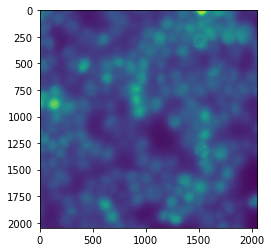

In [25]:
data_loader = s3_storage.DataStorage(s3_dir=s3_dir)

im = data_loader.get_im(first_frame.file_name)
print("Im", im.dtype, im.shape)
plt.imshow(im)
plt.show()

Here we do the same query but instead of fetching just the first result, we fetch all.

In [26]:
all_frames = session.query(Frames) \
    .join(FramesGlobal) \
    .join(DataSet) \
    .filter(DataSet.dataset_serial == dataset_identifier) \
    .filter(Frames.channel_name == channel_name) \
    .all()

stack_shape = (
    all_frames[0].frames_global.im_width,
    all_frames[0].frames_global.im_height,
    all_frames[0].frames_global.im_colors,
    len(all_frames),
)
print("Stack shape:", stack_shape)
bit_depth = all_frames[0].frames_global.bit_depth
print("Bit depth:", bit_depth)
file_names = []
for f in all_frames:
    file_names.append(f.file_name)
    print(f.file_name)

Stack shape: (2048, 2048, 1, 13)
Bit depth: uint16
im_c001_z000_t000_p001.png
im_c001_z001_t000_p001.png
im_c001_z002_t000_p001.png
im_c001_z003_t000_p001.png
im_c001_z004_t000_p001.png
im_c001_z005_t000_p001.png
im_c001_z006_t000_p001.png
im_c001_z007_t000_p001.png
im_c001_z008_t000_p001.png
im_c001_z009_t000_p001.png
im_c001_z010_t000_p001.png
im_c001_z011_t000_p001.png
im_c001_z012_t000_p001.png


Now we can fetch that data from the S3 bucket where they're stored. Plot the first image again.

(2048, 2048, 1, 13)
uint16
24506 272


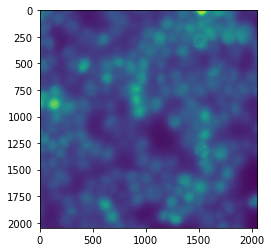

In [27]:
im_stack = data_loader.get_stack(file_names, stack_shape, bit_depth)

print(im_stack.shape)
print(im_stack.dtype)
print(im_stack.max(), im_stack.min())

# Get rid of singleton dimensions in case of grayscale images
im_stack = np.squeeze(im_stack)

plt.imshow(im_stack[..., 0])
plt.show()

Retrieve metadata from dataset and load an image stack using metadata

In [29]:
db_ops = db_session.DatabaseOperations(
    credentials_filename,
    dataset_serial="ISP-2018-06-01-00-00-00-0002",
)
global_meta, frames_meta = db_ops.get_frames_meta()
print(global_meta)

True <class 'bool'>
<class 'bool'>
{'folder_name': 'raw_frames/ISP-2018-06-01-00-00-00-0002', 'nbr_frames': 26, 'im_width': 2048, 'im_height': 2048, 'nbr_slices': 13, 'nbr_channels': 2, 'im_colors': 1, 'nbr_timepoints': 1, 'nbr_positions': 1, 'bit_depth': 'uint16'}


In [30]:
# Print local metadata for each frame
print(frames_meta)

   channel_idx slice_idx time_idx channel_name                   file_name  \
0            0         0        0         DAPI  im_c000_z000_t000_p002.png   
1            0         1        0         DAPI  im_c000_z001_t000_p002.png   
2            0         2        0         DAPI  im_c000_z002_t000_p002.png   
3            0         3        0         DAPI  im_c000_z003_t000_p002.png   
4            0         4        0         DAPI  im_c000_z004_t000_p002.png   
5            0         5        0         DAPI  im_c000_z005_t000_p002.png   
6            0         6        0         DAPI  im_c000_z006_t000_p002.png   
7            0         7        0         DAPI  im_c000_z007_t000_p002.png   
8            0         8        0         DAPI  im_c000_z008_t000_p002.png   
9            0         9        0         DAPI  im_c000_z009_t000_p002.png   
10           0        10        0         DAPI  im_c000_z010_t000_p002.png   
11           0        11        0         DAPI  im_c000_z011_t00

In [32]:
# Get image stack from metadata
importlib.reload(s3_storage)
data_loader = s3_storage.DataStorage(s3_dir=global_meta["s3_dir"])
im_stack, dim_order = data_loader.get_stack_from_meta(global_meta, frames_meta)
print(dim_order)
print(im_stack.shape)

XYZC
(2048, 2048, 13, 2)


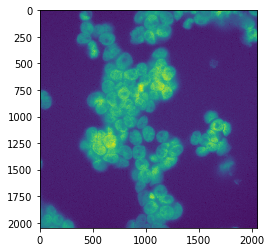

In [33]:
# Plot middle image in first channel
plt.imshow(im_stack[:, :, 7, 0])
plt.show()

In [34]:
session.rollback()
session.close()